# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

c:\Users\admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError as Mae
from keras.optimizers import Adam

In [3]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi': 80})

# Common functions

In [4]:
# Function to check if the dataset is stationary

def is_data_stationary(data):

    # Check if the dataset is stationary in order to provide it to ARIMA model
    result = adfuller(data)

    # extract and print the p-value
    p_value = result[1]

    # check if the time series is stationary based on the p-value
    if p_value < 0.05:
        return 'Data is stationary'
    else:
        return 'Data is not stationary'

In [5]:
# Function to find percentage
# This is mainly used to get more information on MAE and RMSE
# In order to know if its good or worse, selecting a range which is the min and max of the data
# Then checking at what percentage it is
def find_percentage(min, max, value):
    # result = ((value - min) / (max - min)) * 100
    result = (value/(max-min)) * 100
    return result

In [6]:
# For generating sequences of data
def matrix_and_vector_generator(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

# Loading data

In [7]:
path = './O_ID(2102).csv'

station_id = '2102'

df = pd.read_csv(path)

df.head()

,Unnamed: 0.1,Unnamed: 0,O_ID,O_Time,usage,Hour,year
0,4863662,4863662,2102,2018-07-01 00:00:00,14,00:00:00,2018
1,4863663,4863663,2102,2018-07-01 01:00:00,5,01:00:00,2018
2,4863664,4863664,2102,2018-07-01 02:00:00,4,02:00:00,2018
3,4863665,4863665,2102,2018-07-01 03:00:00,1,03:00:00,2018
4,4863666,4863666,2102,2018-07-01 04:00:00,1,04:00:00,2018


In [8]:
# Drop the unwanted columns

df = df[['O_Time', 'usage']]

df['O_Time'] = pd.to_datetime(df['O_Time'])
df.set_index('O_Time', inplace=True)

df.head()

,usage
O_Time,
2018-07-01 00:00:00,14
2018-07-01 01:00:00,5
2018-07-01 02:00:00,4
2018-07-01 03:00:00,1
2018-07-01 04:00:00,1


Text(0, 0.5, 'Usage')

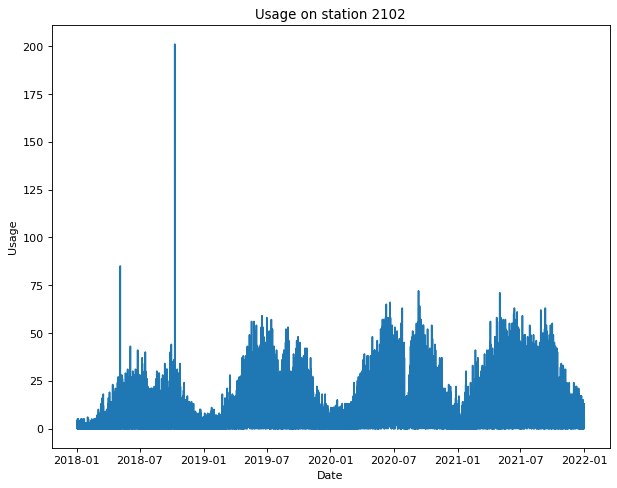

In [9]:
plt.plot(df['usage'])
plt.title('Usage on station ' + station_id)
plt.xlabel('Date')
plt.ylabel('Usage')

# Outlier analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x18660e49d60>,
 'caps': [<matplotlib.lines.Line2D at 0x18660e5e430>,
 'boxes': [<matplotlib.lines.Line2D at 0x18660e49a90>],
 'medians': [<matplotlib.lines.Line2D at 0x18660e5e910>],
 'fliers': [<matplotlib.lines.Line2D at 0x18660e5ebe0>],
 'means': []}

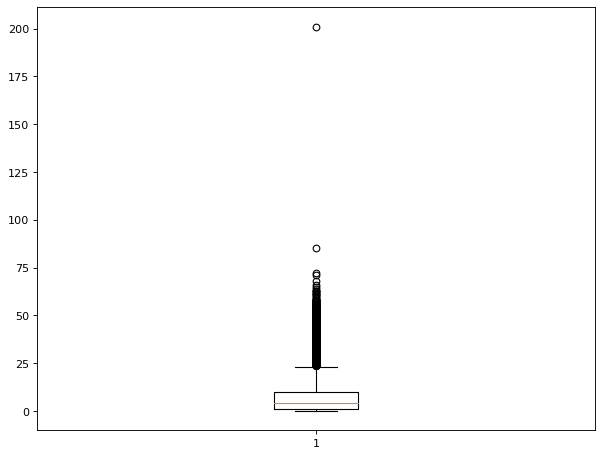

In [10]:
plt.boxplot(df['usage'])

In [11]:
q25, q75 = df['usage'].quantile([0.25, 0.75])

# calculate the interquartile range (IQR)
iqr = q75 - q25

# calculate the upper and lower bounds using the IQR method
upper_bound = q75 + 1.5 * iqr
lower_bound = q25 - 1.5 * iqr

# find the outliers using the IQR method
outliers = df[(df['usage'] > upper_bound) | (df['usage'] < lower_bound)]

# count the number of outliers
num_outliers = len(outliers)

percentage = (num_outliers / len(df['usage'])) * 100

print('Outliers percentage: ', percentage)

Outliers percentage:  7.723011948908116


In [12]:
# Replacing outliers using Z-Score

# Calculate z-score for each data point
z_scores = zscore(df['usage'])

# Identify the outliers
outlier_indices = np.where(np.abs(z_scores) > 3)[0]

# Replace the outliers with the mean of the non-outliers
non_outlier_mean = np.mean(df['usage'][np.abs(z_scores) <= 3])
df['usage'][outlier_indices] = non_outlier_mean

Text(0, 0.5, 'Usage')

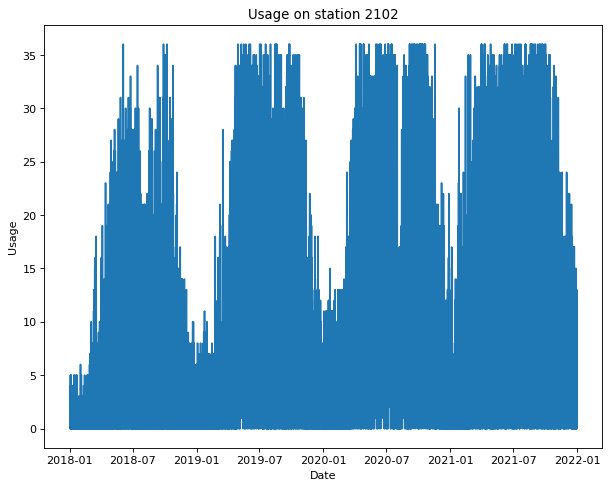

In [13]:
plt.plot(df['usage'])
plt.title('Usage on station ' + station_id)
plt.xlabel('Date')
plt.ylabel('Usage')

# ARIMA Model

In [14]:
split = int(len(df) * 0.8)

train_data = df.iloc[:split]
test_data = df.iloc[split:]

In [15]:
stationarity = is_data_stationary(df['usage'])

if stationarity == True:
    print("Data is stationary")
else:
    print("Data is not stationary")

Data is not stationary


In [16]:
train_data = train_data[['usage']]
test_data = test_data[['usage']]

In [17]:
new_test_data = test_data
new_train_data = train_data

In [18]:
df['usage'].describe()

count    38832.000000
mean         6.486034
std          7.699888
min          0.000000
25%          1.000000
50%          4.000000
75%          9.000000
max         36.000000
Name: usage, dtype: float64

In [19]:
# # Now since the graph is not stationary, turn it to stationary
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt


# df = train_data
# df.value = df.usage

# # Original Series
# fig, axes = plt.subplots(3, 1, sharex=True)
# axes[0].plot(df.value); 
# axes[0].set_title('Original Series')
# axes[0].set_xlabel('Date')
# axes[0].set_ylabel('Count')
# # plot_acf(df.value, ax=axes[0, 1])

# # 1st Differencing
# axes[1].plot(df.value.diff())
# axes[1].set_title('1st Order Differencing')
# axes[1].set_xlabel('Date')
# axes[1].set_ylabel('Count')
# # plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# axes[2].plot(df.value.diff().diff())
# axes[2].set_title('2nd Order Differencing')
# axes[2].set_xlabel('Date')
# axes[2].set_ylabel('Count')

# fig.subplots_adjust(hspace=0.5)
# plt.show()

# # On 2nd order differencing we are loosing more information so considering 1st order differencing
# # d can be taken as 1
d = 0

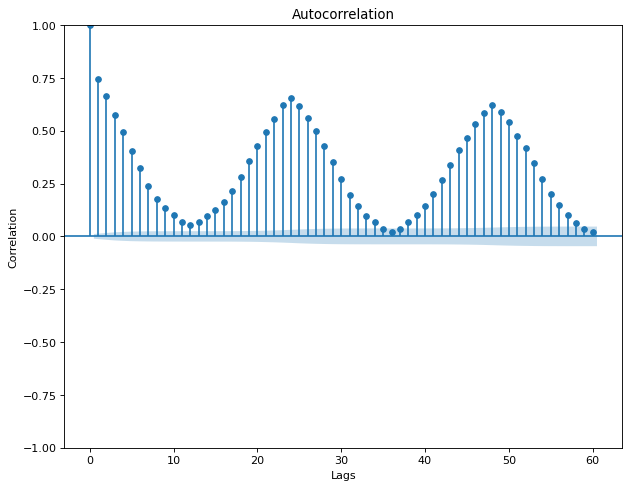

In [20]:
plot_acf(new_train_data['usage'], lags = 60)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

p = 8

# There is no significant change after the 8th lag
# So p = 8

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


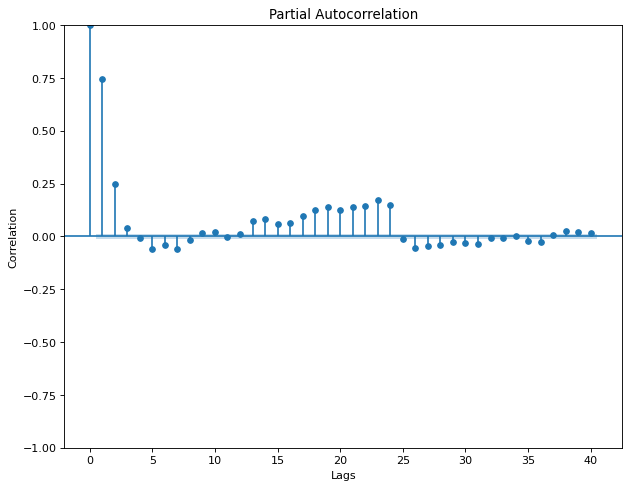

In [21]:
plot_pacf(new_train_data['usage'], lags = 40)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

q = 3
# q value can be taken as 3

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(new_train_data['usage'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\admin\anaconda3\lib\site-

                               SARIMAX Results                                
Dep. Variable:                  usage   No. Observations:                31065
Model:                 ARIMA(8, 0, 3)   Log Likelihood              -92291.418
Date:                Mon, 24 Apr 2023   AIC                         184608.835
Time:                        08:06:04   BIC                         184717.305
Sample:                             0   HQIC                        184643.581
                              - 31065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8193      0.229     25.392      0.000       5.370       6.269
ar.L1          0.1358      0.057      2.401      0.016       0.025       0.247
ar.L2         -0.0387      0.059     -0.657      0.5

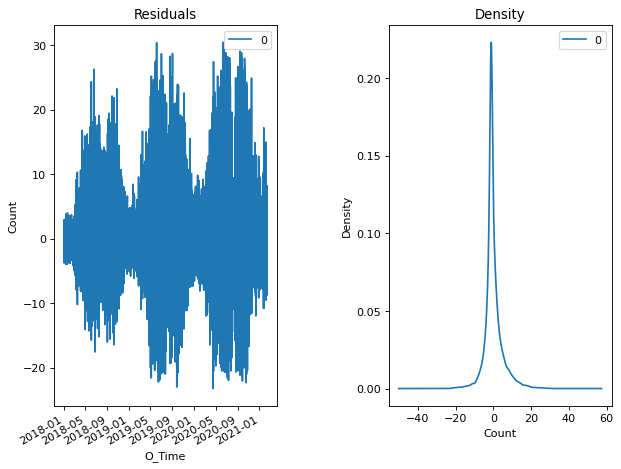

In [23]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.subplots_adjust(wspace=0.5)
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Count')
plt.show()

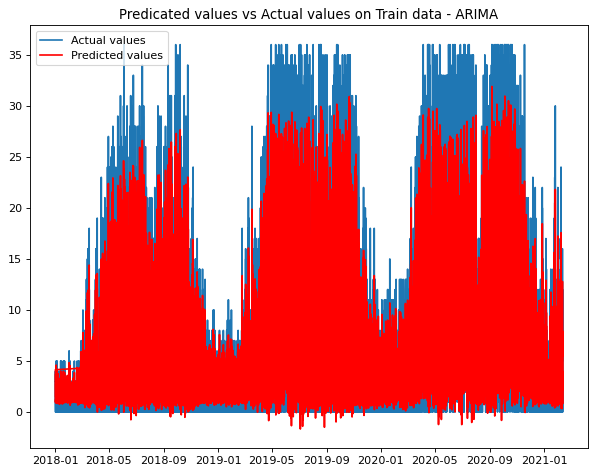

In [24]:
plt.plot(new_train_data['usage'], label='Actual values')
plt.plot(model_fit.fittedvalues, color='red', label='Predicted values')
plt.title('Predicated values vs Actual values on Train data - ARIMA')
plt.legend()

In [25]:
print("Result for train data:")
rmse = np.sqrt(mean_squared_error(new_train_data['usage'], model_fit.fittedvalues))
mae = mean_absolute_error(new_train_data['usage'], model_fit.fittedvalues)

min = new_train_data['usage'].min()
max = new_train_data['usage'].max()

print("RMSE: ", rmse, " - percentage: ", str(find_percentage(min, max, rmse)))
print("MAE: ", mae, " - percentage: ", str(find_percentage(min, max, mae)))

Result for train data:
RMSE:  4.720729109909938  - percentage:  13.113136416416497
MAE:  3.0689685413814116  - percentage:  8.524912614948366


In [26]:
steps = len(new_test_data.index)

In [27]:
start = len(new_train_data)
end = start + steps - 1
result = model_fit.predict(start=start, end=end, type='levels')
result

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


31065    2.318058
31066    2.150442
31067    2.896122
31068    3.862768
31069    4.259928
           ...   
38827    5.819341
38828    5.819341
38829    5.819341
38830    5.819341
38831    5.819341
Name: predicted_mean, Length: 7767, dtype: float64

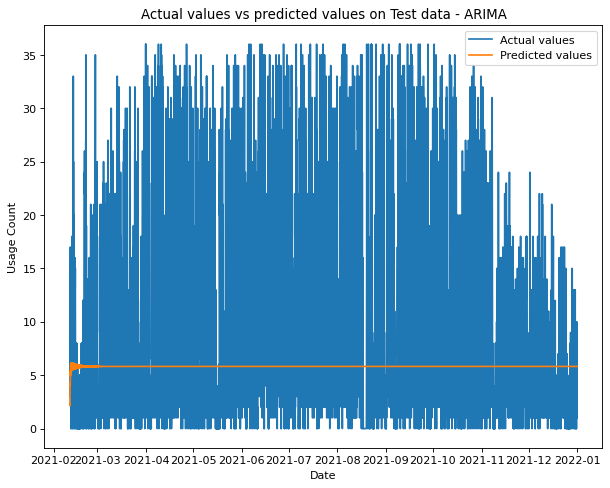

In [28]:
test = new_test_data[:steps]

plt.plot(test.index, test['usage'], label='Actual values')
plt.plot(test.index, result, label='Predicted values')
plt.title('Actual values vs predicted values on Test data - ARIMA')
plt.xlabel('Date')
plt.ylabel('Usage Count')
plt.legend()
plt.show()

In [29]:
print("For Test Data: ")

testing = new_test_data['usage']

rmse = np.sqrt(mean_squared_error(testing[:steps], result))
mae = mean_absolute_error(testing[:steps], result)

min = new_test_data['usage'].min()
max = new_test_data['usage'].max()

print("RMSE: ", rmse, " - percentage: ", str(find_percentage(min, max, rmse)))
print("MAE: ", mae, " - percentage: ", str(find_percentage(min, max, mae)))

For Test Data: 
RMSE:  8.947207727689609  - percentage:  24.853354799137804
MAE:  6.1370558834435975  - percentage:  17.047377454009993


# LSTM

In [30]:
WINDOW_SIZE=24

data = df.copy()
data.tail()

,usage
O_Time,
2021-12-31 19:00:00,3.0
2021-12-31 20:00:00,4.0
2021-12-31 21:00:00,5.0
2021-12-31 22:00:00,5.0
2021-12-31 23:00:00,1.0


In [64]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = data['usage']

total_length = len(col)

train_ratio, validation_ratio = 0.7, 0.15

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

In [65]:
x_train,y_train = matrix_and_vector_generator(train_data, WINDOW_SIZE)
x_validation, y_validation = matrix_and_vector_generator(validation_data, WINDOW_SIZE)
x_test, y_test = matrix_and_vector_generator(test_data, WINDOW_SIZE)

print("Train Shape: ", str(x_train.shape),' - ', str(y_train.shape))
print("Validation Shape: ", str(x_validation.shape),' - ', str(y_validation.shape))
print("Test Shape: ", str(x_test.shape),' - ', str(y_test.shape))

Train Shape:  (27158, 24)  -  (27158,)
Validation Shape:  (5800, 24)  -  (5800,)
Test Shape:  (5802, 24)  -  (5802,)


In [66]:
model1 = Sequential()

model1.add(InputLayer((WINDOW_SIZE, 1)))

model1.add(LSTM(128, activation='relu'))
model1.add(Dense(96, activation='relu'))
model1.add(Dense(96, activation='relu'))
model1.add(Dense(1, activation='relu'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_6 (Dense)             (None, 96)                12384     
                                                                 
 dense_7 (Dense)             (None, 96)                9312      
                                                                 
 dense_8 (Dense)             (None, 1)                 97        
                                                                 
Total params: 88,353
Trainable params: 88,353
Non-trainable params: 0
_________________________________________________________________


In [67]:
cp = ModelCheckpoint('model-lstm-new/', save_best_only=True)
model1.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[Mae()])

In [68]:
history = model1.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=10, callbacks=[cp])

Epoch 1/10
849/849 [==============================] - 18s 20ms/step - loss: 2.7793 - mean_absolute_error: 2.7793 - val_loss: 3.6376 - val_mean_absolute_error: 3.6376
Epoch 2/10
849/849 [==============================] - 50s 59ms/step - loss: 2.5120 - mean_absolute_error: 2.5120 - val_loss: 3.5960 - val_mean_absolute_error: 3.5960
Epoch 3/10
849/849 [==============================] - 21s 24ms/step - loss: 2.4864 - mean_absolute_error: 2.4864 - val_loss: 3.5678 - val_mean_absolute_error: 3.5678
Epoch 4/10
849/849 [==============================] - 16s 19ms/step - loss: 2.4753 - mean_absolute_error: 2.4753 - val_loss: 3.5528 - val_mean_absolute_error: 3.5528
Epoch 5/10
849/849 [==============================] - 15s 17ms/step - loss: 2.4593 - mean_absolute_error: 2.4593 - val_loss: 3.5456 - val_mean_absolute_error: 3.5456
Epoch 6/10
849/849 [==============================] - 19s 22ms/step - loss: 2.4506 - mean_absolute_error: 2.4506 - val_loss: 3.6249 - val_mean_absolute_error: 3.6249
Epoc

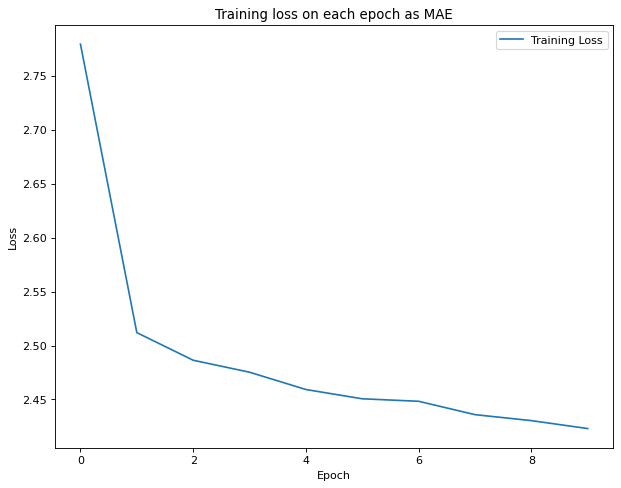

In [69]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training loss on each epoch as MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
from keras.models import load_model

model1 = load_model('model-lstm-new/')

In [71]:
train_predictions = model1.predict(x_train).flatten()

849/849 [==============================] - 5s 6ms/step


In [72]:
train_predictions.shape, y_train.shape

((27158,), (27158,))

In [73]:
train_results = pd.DataFrame(data={'Train predictions': train_predictions, 'Actuals' : y_train} )

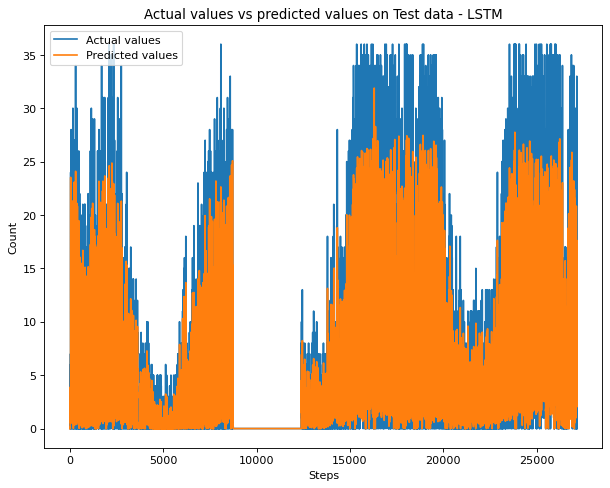

In [74]:
size = None

predictions = None
actuals = None

if size != None:
    predictions = train_results['Train predictions'][:size]
    actuals = train_results['Actuals'][:size]
else:
    predictions = train_results['Train predictions'][:]
    actuals = train_results['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values on Test data - LSTM')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [75]:
from sklearn.metrics import mean_squared_error, median_absolute_error

actuals = train_results['Actuals']
predicted = train_results['Train predictions']

print("For Train data:")

min = train_results['Actuals'].min()
max = train_results['Actuals'].max()

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae), 'Percentage: ', str(find_percentage(min, max, mae)))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse, 'Percentage: ', str(find_percentage(min, max, rmse)))

For Train data:
MAE:  2.4256900836068493 Percentage:  6.7380280100190255
RMSE: 4.088067867259734 Percentage:  11.355744075721482


In [76]:
test_predictions = model1.predict(x_test).flatten()

182/182 [==============================] - 1s 7ms/step


In [77]:
test_predictions.shape, y_test.shape

((5802,), (5802,))

In [78]:
test_results = pd.DataFrame(data={'Test predictions': test_predictions, 'Actuals' : y_test} )

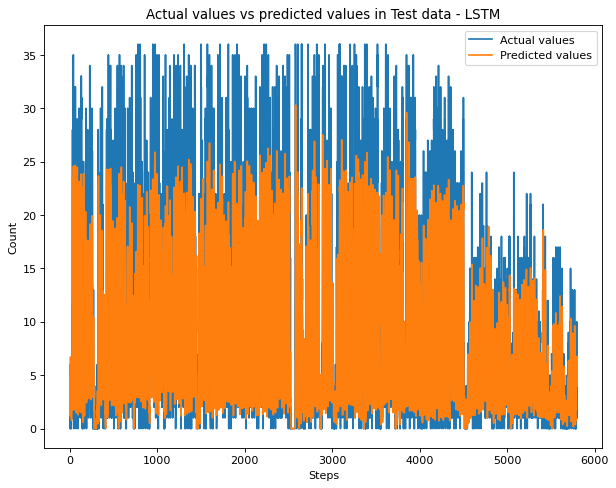

In [79]:
size = None

predictions = None
actuals = None

x = test_results

if size != None:
    predictions = x['Test predictions'][:size]
    actuals = x['Actuals'][:size]
else:
    predictions = x['Test predictions'][:]
    actuals = x['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Test data - LSTM')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [80]:
actuals = test_results['Actuals']
predicted = test_results['Test predictions']

min = actuals.min()
max = actuals.max()

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae), ' Percentage: ', str(find_percentage(min, max, mae)))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse, 'Percentage: ', str(find_percentage(min, max, rmse)))

MAE:  4.223646228165514  Percentage:  11.732350633793093
RMSE: 6.200233372281094 Percentage:  17.222870478558594


# GRU

In [66]:
data = df.copy()
data.head()

,usage
O_Time,
2018-07-01 00:00:00,14.0
2018-07-01 01:00:00,5.0
2018-07-01 02:00:00,4.0
2018-07-01 03:00:00,1.0
2018-07-01 04:00:00,1.0


In [67]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = data['usage']

total_length = len(col)

train_ratio, validation_ratio = 0.8, 0.1

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

In [68]:
WINDOW_SIZE = 24

x_train,y_train = matrix_and_vector_generator(train_data, WINDOW_SIZE)
x_validation, y_validation = matrix_and_vector_generator(validation_data, WINDOW_SIZE)
x_test, y_test = matrix_and_vector_generator(test_data, WINDOW_SIZE)

print("Train Shape: ", str(x_train.shape),' - ', str(y_train.shape))
print("Validation Shape: ", str(x_validation.shape),' - ', str(y_validation.shape))
print("Test Shape: ", str(x_test.shape),' - ', str(y_test.shape))

Train Shape:  (31041, 24)  -  (31041,)
Validation Shape:  (3859, 24)  -  (3859,)
Test Shape:  (3860, 24)  -  (3860,)


In [84]:
model2 = Sequential()

model2.add(InputLayer((WINDOW_SIZE, 1)))

model2.add(GRU(96, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(48, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 96)                28512     
                                                                 
 dense_11 (Dense)            (None, 48)                4656      
                                                                 
 dense_12 (Dense)            (None, 48)                2352      
                                                                 
 dense_13 (Dense)            (None, 1)                 49        
                                                                 
Total params: 35,569
Trainable params: 35,569
Non-trainable params: 0
_________________________________________________________________


In [85]:
cp = ModelCheckpoint('model-gru-new/', save_best_only=True)
model2.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[Mae()])

In [86]:
history = model2.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=15, callbacks=[cp])

Epoch 1/15
970/971 [============================>.] - ETA: 0s - loss: 3.0806 - mean_absolute_error: 3.0806INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 48s 48ms/step - loss: 3.0806 - mean_absolute_error: 3.0806 - val_loss: 4.5857 - val_mean_absolute_error: 4.5857
Epoch 2/15
970/971 [============================>.] - ETA: 0s - loss: 2.6543 - mean_absolute_error: 2.6543INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 47s 48ms/step - loss: 2.6542 - mean_absolute_error: 2.6542 - val_loss: 4.5167 - val_mean_absolute_error: 4.5167
Epoch 3/15
971/971 [==============================] - 39s 40ms/step - loss: 2.6266 - mean_absolute_error: 2.6266 - val_loss: 4.6343 - val_mean_absolute_error: 4.6343
Epoch 4/15
971/971 [==============================] - ETA: 0s - loss: 2.6144 - mean_absolute_error: 2.6144INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 43s 45ms/step - loss: 2.6144 - mean_absolute_error: 2.6144 - val_loss: 4.4966 - val_mean_absolute_error: 4.4966
Epoch 5/15
970/971 [============================>.] - ETA: 0s - loss: 2.5903 - mean_absolute_error: 2.5903INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 38s 39ms/step - loss: 2.5904 - mean_absolute_error: 2.5904 - val_loss: 4.4760 - val_mean_absolute_error: 4.4760
Epoch 6/15
971/971 [==============================] - 30s 31ms/step - loss: 2.5858 - mean_absolute_error: 2.5858 - val_loss: 4.5046 - val_mean_absolute_error: 4.5046
Epoch 7/15
969/971 [============================>.] - ETA: 0s - loss: 2.5744 - mean_absolute_error: 2.5744INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 38s 40ms/step - loss: 2.5750 - mean_absolute_error: 2.5750 - val_loss: 4.4654 - val_mean_absolute_error: 4.4654
Epoch 8/15
971/971 [==============================] - ETA: 0s - loss: 2.5680 - mean_absolute_error: 2.5680INFO:tensorflow:Assets written to: model-gru-new\assets


INFO:tensorflow:Assets written to: model-gru-new\assets


971/971 [==============================] - 50s 52ms/step - loss: 2.5680 - mean_absolute_error: 2.5680 - val_loss: 4.4494 - val_mean_absolute_error: 4.4494
Epoch 9/15
346/971 [=========>....................] - ETA: 27s - loss: 2.5190 - mean_absolute_error: 2.5190

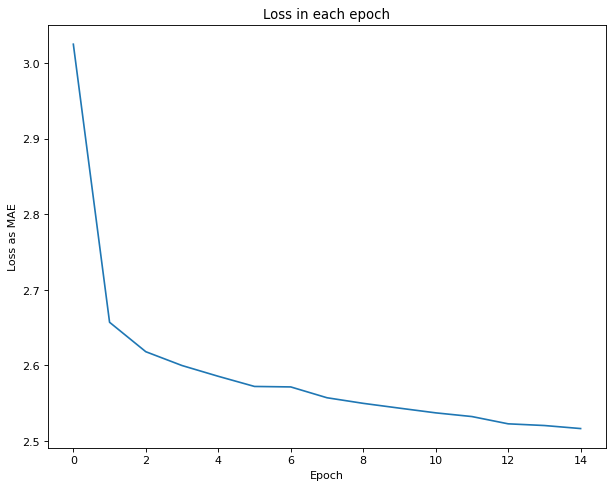

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss as MAE')
plt.title("Loss in each epoch")
plt.show()

In [ ]:
from keras.models import load_model

model2 = load_model('model-gru-new/')

In [ ]:
train_predictions = model2.predict(x_train).flatten()

971/971 [==============================] - 16s 16ms/step


In [ ]:
train_predictions.shape, y_train.shape

((31041,), (31041,))

In [ ]:
train_results = pd.DataFrame(data={'Train predictions': train_predictions, 'Actuals' : y_train} )

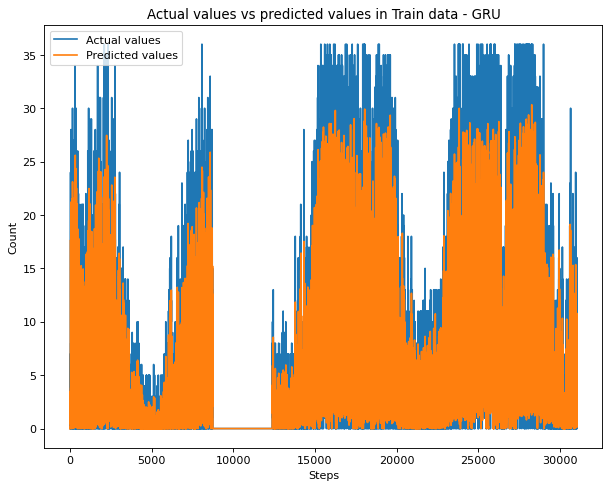

In [ ]:
size = None

predictions = None
actuals = None

if size != None:
    predictions = train_results['Train predictions'][:size]
    actuals = train_results['Actuals'][:size]
else:
    predictions = train_results['Train predictions'][:]
    actuals = train_results['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Train data - GRU')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, median_absolute_error

actuals = train_results['Actuals']
predicted = train_results['Train predictions']

print("For Train data:")

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

For Train data:
MAE:  2.517911051170316
RMSE: 4.2112145837805


In [ ]:
test_predictions = model2.predict(x_test).flatten()

121/121 [==============================] - 2s 15ms/step


In [ ]:
test_predictions.shape, y_test.shape

((3860,), (3860,))

In [ ]:
test_results = pd.DataFrame(data={'Test predictions': test_predictions, 'Actuals' : y_test} )

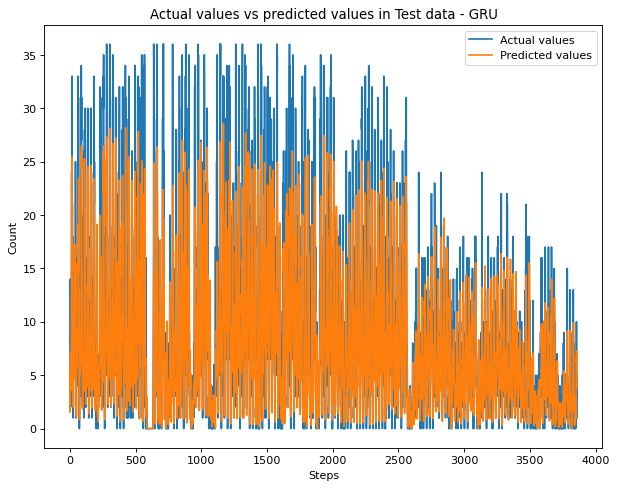

In [ ]:
size = None

predictions = None
actuals = None

x = test_results

if size != None:
    predictions = x['Test predictions'][:size]
    actuals = x['Actuals'][:size]
else:
    predictions = x['Test predictions'][:]
    actuals = x['Actuals'][:]

plt.plot(actuals, label='Actual values')
plt.plot(predictions, label='Predicted values')
plt.title('Actual values vs predicted values in Test data - GRU')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.legend()

In [ ]:
actuals = test_results['Actuals']
predicted = test_results['Test predictions']

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

# calculate MSE
rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

MAE:  3.7959920352416625
RMSE: 5.676364607688356
